In [128]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse,signal,interpolate
from numpy import polynomial

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from partial_trace import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font',size=10)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

$\renewcommand{\vec}{\mathbf}$

Now we will visualize the results of the experiment.

In [3]:
directory = f'data/example_data'
data_directory = 'data'

Let's load all of the data files. We'll then store the output of the experiment in a array called `out_all` and a list of the $h$ values in an array called `hs`. These will be sorted by the value of $h$.

In [4]:
# load parameters
[s,N,N_s] = np.load(f'{directory}/dimensions.npy',allow_pickle=True)
N = int(N)
N_s = int(N_s)

In [6]:
out_all = []
hs = []
for file in os.listdir(f'{directory}/{data_directory}'):
    
    # only look at npy files
    if file[-4:] != '.npy':
        continue
    
    data = np.load(f'{directory}/data/{file}',allow_pickle=True).item()
    hs.append(data['h'])
    out_all.append(data['out'])

hs,out_all = zip(*sorted(zip(hs,out_all)))
hs = np.array(hs)

Now we will process the data to compute the von Neumann entropy for each $h$ value at all of the specified $\beta$ values.

In [61]:
n_βs = 30
βs = np.hstack([[1e5,1e4],1/np.logspace(-3,1.5,n_βs-2)])


vN_entropy_all = []
for hi,h in enumerate(hs):

    (Λk,Tr_defl),(Θs,Tr_rems) = out_all[hi]
    E0 = Λk[0]

    vN_entropy = get_vN_entropy(Λk,Tr_defl,Θs,Tr_rems,E0,βs)
    vN_entropy_all.append(vN_entropy)

hs_full = np.linspace(hs[0],hs[-1],500)
vN_entropy_true_all = []
for hi,h in enumerate(hs_full):
    
    vN_entropy_true = get_vN_entropy_true(h,1,N,βs)
    vN_entropy_true_all.append(vN_entropy_true)

Finally, we're ready to plot. For each value of $\beta$ we can simply add a curve to our plot.
For this example, which is exactly solvable, we can also compute the exact values of the von Neumann entropy.

In [62]:
turning_points = np.load(f'{directory}/turning_points.npy')

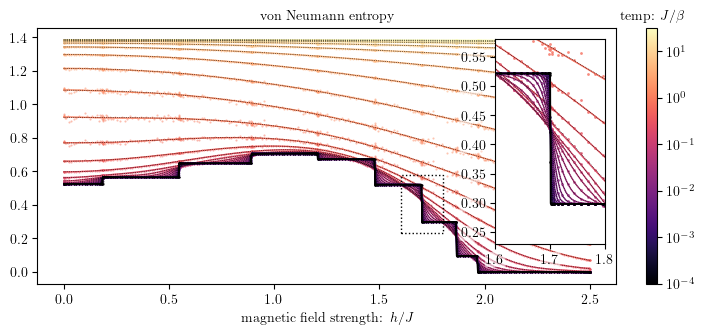

In [130]:

βs_to_int = lambda β: (np.log10(βs[1]) - np.log10(β)) / (np.log10(βs[1])-np.log10(βs[-1]))

fig,axs = plt.subplots(1,2,figsize=(8,3.5),gridspec_kw={'width_ratios': [1,.02]})

plt.subplots_adjust(bottom=.15,wspace=.1)

axins = inset_axes(axs[0], "19%","80%", loc='upper right', borderpad=.8) # zoom = 6


for l,β in enumerate(βs):
    c = (plt.cm.magma(βs_to_int(β)) if l>0 else 'k')

    axs[0].plot(hs_full,np.array(vN_entropy_true_all)[:,l],color='k',ls=':',lw=.5)
    axins.plot(hs_full,np.array(vN_entropy_true_all)[:,l],color='k',ls=':',lw=.5)
    
    # get y values for a single temperature
    y = np.array(vN_entropy_all)[:,l]

    if True or image_type == 'crop':
        axs[0].plot(hs,y,color=c,ls='None',marker='.',ms=3,alpha=.5,markeredgewidth=0,zorder=-l)
        axins.plot(hs,y,color=c,ls='None',marker='.',ms=4,alpha=.8,markeredgewidth=0,zorder=-l)
        
    if β < 5e0:
        deg = 10
        p = polynomial.chebyshev.Chebyshev.fit(hs,y,deg)
        axs[0].plot(hs_full,p(hs_full),color=c,lw=1,zorder=-l)
        axins.plot(hs_full,p(hs_full),color=c,lw=1,zorder=-l)

    elif β < 5e2:
        tck = sp.interpolate.splrep(hs,y,s=0)
        axs[0].plot(hs_full,sp.interpolate.BSpline(*tck)(hs_full),color=c,lw=1,zorder=-l)
        axins.plot(hs_full,sp.interpolate.BSpline(*tck)(hs_full),color=c,lw=1,zorder=-l)
    else:
        axs[0].plot(hs,y,color=c,lw=1,zorder=-l)
        axins.plot(hs,y,color=c,lw=1,zorder=-l)


cmap = plt.get_cmap('magma')
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
Ts = np.array([1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2])
cbar = plt.colorbar(sm,ticks=βs_to_int(1/Ts),cax=axs[-1])
cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(T))}}}$' for T in Ts]);  # vertically oriented colorbar
axs[-1].set_title('temp: $J/\\beta$',fontsize=10)

x1,x2 = 1.6,1.8
y1,y2 = .23,.58
# x1,x2 = 1.18,1.23
# y1,y2 = .66,.72

axs[0].add_patch(Rectangle((x1,y1),x2-x1,y2-y1,fill=False,ls=':',zorder=100))
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)

bs = mpl.patches.BoxStyle.Round(pad=.1)
bbox = dict(boxstyle=bs, ec="None", fc="white", alpha=0.6)
plt.setp(axins.get_xticklabels(), bbox=bbox)
plt.setp(axins.get_yticklabels(), bbox=bbox)

axs[0].set_xlabel('magnetic field strength: $h/J$')    
axs[0].set_title('von Neumann entropy',fontsize=10)

plt.savefig(f'imgs/vN_phase_exact.pdf',dpi=300)